<a href="https://colab.research.google.com/github/Rocky12312/Toxic-Comment-Classification/blob/master/Toxic_comment_classification_using_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
cd drive/My\ Drive/Toxic_comment_classification

/content/drive/My Drive/Toxic_comment_classification


In [0]:
import re
import os
import sys
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Reading the data from train.csv containing the comments and their corresponding labels

In [4]:
df = pd.read_csv("train.csv")
df.head(5)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [5]:
df.isnull().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

In [6]:
#Getting infor the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


From the data info and null status it is clear that our data contains 1,59,571 records and there is no null value in our data so we need not to care about impytations and other such stuff

In [0]:
#Replacing all the nan with the dummy values if there are any
sentences = df["comment_text"].fillna("Dummy_Value").values
#This sentences is our input data which we will be feeding to our model after preprocessing the data
target = df[["toxic","severe_toxic","obscene","threat","insult","identity_hate"]].values

One of the main thing in this problem is that we have 6 label in our output and we need to classify our comment in all of them(means we have to give the status of each and every label corresponding to the comment)

Our output is N*6, where N is the number of samples or say the records in our data and 6 are the labels.

Now getting the maximum,minimum and median sequence length from our sentences

In [8]:
print("Maximum sequence length: ",max(len(s) for s in sentences))
print("Minimum sequence length: ",min(len(s) for s in sentences))
seq_len = sorted(len(s) for s in sentences)
print("Median sequence length: ",seq_len[len(seq_len)//2])

Maximum sequence length:  5000
Minimum sequence length:  6
Median sequence length:  205


  Now it is clear that our maximum sequence length and minimum sequence length are far apart from each other so we need to take this variation our consideration and convert each and every comment to a fixed length by padding

The first thing which we shoul do is preprocess our text and male it free from stopwords,punctuations etc

In [0]:
def preprocessing_text(text_data):
  for i in range(len(text_data)):
    #Lowering the text
    text = text_data[i].lower()
    #Splitting the text into tokens
    tokens = text.split()
    #Preparing regex for character filtering
    re_punct = re.compile("[%s]"% re.escape(string.punctuation))
    tokens = [re_punct.sub(" ", word) for word in tokens]
    #Removing stopwords
    tokens = [word for word in tokens if word not in set(stopwords.words("english"))]
    #Now joining tokens back to form sentence
    text_data[i] = " ".join(tokens)
  return text_data

In [10]:
#Now preprocessing our text_data
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
comment_sentences = preprocessing_text(sentences)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Now the next thing which we will be doing is tokenizing using tokenizer so as to convert each and every sentence to a vector of their index numbers

Here in tokenizer we have to also input the size of vocabulary which we will be using for text to numeric conversion

Taking maximum vocabulary size to be 20000 and its upon us to take whatever we want but the best choice of vocab size found upto now is 20000

In [11]:
from keras.preprocessing.text import Tokenizer
Max_vocab_size = 20000
tokenizer = Tokenizer(num_words = Max_vocab_size)
#Now fitting tokenizer on our input data
tokenizer.fit_on_texts(comment_sentences)
#Converting each and every sentence to a vector of their word index(replacing word with their indexes)
sequences = tokenizer.texts_to_sequences(comment_sentences)

Using TensorFlow backend.


In [0]:
#Our tokenizer also provide us something which help in integer to word mapping
word2idx = tokenizer.word_index

Now as we have a vector corresponding to each sentences so next we gonna be embedding each and every word to some vector in multidimensional space either by training our own word embedding or by using some pretrained word embedding like glove etc

In [13]:
#Here we will be using Glove word vectors
#First creating a dictonary of word to vectors(initializing a empty dictionary)
word2vec = {}
with open(os.path.join("glove.6B.100d.txt")) as f:
  for line in f:
    values = line.split()
    word = values[0]
    vec = np.asarray(values[1:],dtype = "float32")
    word2vec[word] = vec
print("No of word to vectors in glove word 2 vec: ",len(word2vec))
#So here basically we created a dictionary having words as index and corresponding vectors as values

No of word to vectors in glove word 2 vec:  400000


Now next step which we gonna do is create a embedding matrix which we will use for mapping each of the word of our sentence to a vector 

In [0]:
#These num_words will be our vocabulary size
#Embedding_dim will be the size of our embeddings(word vectors), which will be 100 as in glove 100d each word contain a corresponding vector of 100d
num_words = min(Max_vocab_size,len(word2idx)+1)
Embedding_dim = 100
embedding_matrix = np.zeros((num_words,Embedding_dim))
for word,i in word2idx.items():
  if i<Max_vocab_size:
    embedding_vector = word2vec.get(word)
    if embedding_vector is not None:
      embedding_matrix[i] = embedding_vector
#This is the way we gonna fill our embedding matrix with word vectors

In [15]:
comment_sentences

array(['explanation edits made username hardcore metallica fan reverted  weren t vandalisms  closure gas voted new york dolls fac  please don t remove template talk page since i m retired now 89 205 38 27',
       'd aww  matches background colour i m seemingly stuck with  thanks   talk  21 51  january 11  2016  utc ',
       'hey man  i m really trying edit war  it s guy constantly removing relevant information talking edits instead talk page  seems care formatting actual info ',
       ...,
       'spitzer umm  theres actual article prostitution ring    crunch captain ',
       'looks like actually put speedy first version deleted look it ',
       '      really don t think understand  came idea bad right away  kind community goes   you bad ideas   go away  instead helping rewrite them   '],
      dtype=object)

Now one of the most important thing is to pad the input so that they all have same length

In [0]:
from keras.preprocessing.sequence import pad_sequences
#Here we have to define a maximum sequence length so that each sequences can be bought to this length
Max_sequence_length = 100
#100 randomly choosen
comment_sen = pad_sequences(sequences,maxlen = Max_sequence_length)
#Now this comment_sen will be our input data

Now as we have our padded sequences of comments vector where at each word position thre is index corresponding to the word

Now we will be creating the embedding layer(input will go to embedding layer befor being fed to RNN unit or CNN unit)

In [0]:
from keras.layers import Embedding
embedding_layer = Embedding(num_words,Embedding_dim,weights = [embedding_matrix],input_length = Max_sequence_length,trainable = False)

Basically setting trainable to false means that we are going to take the pretrained weights(embedding vectors) and not training them and also we can set trainable to true but actually there is no need as these embedding are quite good have been trained on a very huge corpus from wikipedia and on a large cluster size which aren't possible on a single system 

Now lets build the model and there can be lots and lots of architecture which we can use for this task and compare their accuracy

In [0]:
from keras.layers import Input,LSTM,GRU,GlobalMaxPooling1D,Dense
from keras.models import Model
input_ = Input(shape=(Max_sequence_length,))
x = embedding_layer(input_)
x = LSTM(80,return_sequences = True)(x)
x = GlobalMaxPooling1D()(x)
#Output layer with six neurons as we have six labels in output
output = Dense(6,activation = "sigmoid")(x)
#Output will be as six binary classifications when we take take 6 dense output layer insted of 1 layer with 6 nodes
model = Model(input_,output)

if we use 6 output layer then our output will contain 6 outputs fed by the embedding layer and our output label will be seperate for the target variable target1 to target 6 for each label will be fed to the model

output1 = Dense(1, activation="sigmoid")(x)

output2 = Dense(1, activation="sigmoid")(x)

output3 = Dense(1, activation="sigmoid")(x)

output4 = Dense(1, activation="sigmoid")(x)

output5 = Dense(1, activation="sigmoid")(x)

output6 = Dense(1, activation="sigmoid")(x)

In [0]:
#Now compiling the model
model.compile(loss = "binary_crossentropy",optimizer = "rmsprop",metrics = ["accuracy"])

In [20]:
#Now fitting the model on the input and output data
ht = model.fit(comment_sen,target,batch_size = 128,epochs = 5,validation_split = 0.2)

Train on 127656 samples, validate on 31915 samples
Epoch 1/5
127656/127656 [==============================] - 241s 2ms/step - loss: 0.0774 - accuracy: 0.9747 - val_loss: 0.0609 - val_accuracy: 0.9789
Epoch 2/5
127656/127656 [==============================] - 237s 2ms/step - loss: 0.0558 - accuracy: 0.9803 - val_loss: 0.0568 - val_accuracy: 0.9796
Epoch 3/5
127656/127656 [==============================] - 241s 2ms/step - loss: 0.0515 - accuracy: 0.9815 - val_loss: 0.0531 - val_accuracy: 0.9809
Epoch 4/5
127656/127656 [==============================] - 237s 2ms/step - loss: 0.0487 - accuracy: 0.9822 - val_loss: 0.0515 - val_accuracy: 0.9812
Epoch 5/5
127656/127656 [==============================] - 239s 2ms/step - loss: 0.0467 - accuracy: 0.9828 - val_loss: 0.0516 - val_accuracy: 0.9809


Plotting the loss and accuracy curve

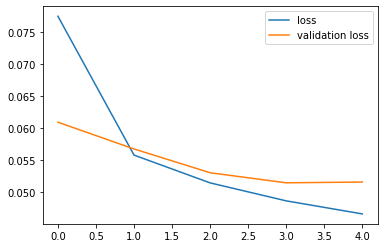

In [21]:
plt.plot(ht.history["loss"],label = "loss")
plt.plot(ht.history["val_loss"],label = "validation loss")
plt.legend()
plt.show()

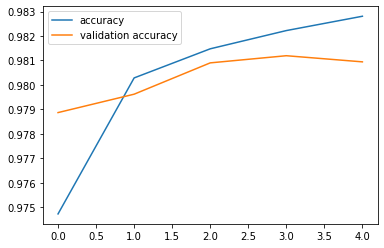

In [22]:
plt.plot(ht.history["accuracy"],label = "accuracy")
plt.plot(ht.history["val_accuracy"],label = "validation accuracy")
plt.legend()
plt.show()

In [23]:
from sklearn.metrics import roc_auc_score
#Plotting the mean auc for each label
p_d = model.predict(comment_sen)
aucs=[]
for i in range(6):
  auc = roc_auc_score(target[:,i],p_d[:,i])
  aucs.append(auc)
print(np.mean(aucs))

0.9828259625930905


In [0]:
#Saving the model
model.save("model_LSTM.h5")

In [25]:
#Loading the model for evaluating it on test data
from numpy import loadtxt
from keras.models import load_model
model = load_model("model_LSTM.h5")
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 100, 100)          2000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 80)           57920     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 80)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 486       
Total params: 2,058,406
Trainable params: 58,406
Non-trainable params: 2,000,000
_________________________________________________________________
